In [ ]:
import argparse
import sys
import os
from skimage import io

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.patches as mpatches

from tqdm import tqdm

# from scheduler import CycleScheduler
from pt_utils import  Embeddings, Trainer, VQVAE, data_sampler, Vqvae2Adaptive
from torch.utils import data
from torch import distributed as dist

from umap import UMAP
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from skimage import transform, metrics
import skimage
import pandas as pd
import numpy as np
import glob

from torchsummary import summary

# from tqdm.notebook import trange, tqdm
from tqdm import trange, tqdm
import torchvision
from PIL import Image

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import scipy as sp
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import joblib
import pickle

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

seed = 51
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
dataset_path = '../datasets/original/o_bc_left_9x_512_360'

resize_shape = (512, 512)

transform = transforms.Compose(
    [   
        # transforms.CenterCrop((256,256)),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize(0.5, 0.5),
    ]
)

dataset = datasets.ImageFolder(dataset_path, transform=transform)

model_file = 'data/logs/emb_dim_1_n_embed_8192_o_bc_left_9x_512_360_1/vqvae_003_train_0.01967_test_0.01958.pt'



device = "cuda"

model =    VQVAE(in_channel=1,
# model =    Vqvae2Adaptive(in_channel=1,
                   channel=128,
                   n_res_block=6,
                   n_res_channel=32,
                   embed_dim=1,
                   n_embed=8192,
                   decay=0.99).to(device)

model.load_state_dict(torch.load(model_file, map_location=torch.device('cuda')))

<All keys matched successfully>

In [35]:
# model.__dict__['_modules']

In [36]:
# model.__dict__['_modules']['enc_b'].__dict__['_modules']['blocks'].__dict__['_modules']

In [70]:
# model.__dict__['_modules']

In [71]:
dataset_path = dataset.__dict__['root']
classes_folders = os.listdir(dataset_path)
classes_folders_images = [os.listdir(dataset_path + '/' + folder) for folder in classes_folders]
classes_folders_images_num = [len(os.listdir(dataset_path + '/' + folder)) for folder in classes_folders]
img_transform = dataset.__dict__['transform']

i=0
j=0

image_path = dataset_path + '/' + classes_folders[i] + '/' + classes_folders_images[i][j]

image = Image.open(image_path)
image = transform(image)
image = image.unsqueeze(0).to(device)

# print(image.shape)

quant_t, quant_b, diff, _, indx_b = model.encode(image)

print(quant_t.shape)
# print(quant_t.cpu().detach().numpy().flatten().shape)
print(quant_b.shape)
# print(quant_b.cpu().detach().numpy().flatten().shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 128, 128])


In [16]:
res=model.decode(quant_t, quant_b)

res.shape

torch.Size([1, 1, 512, 512])

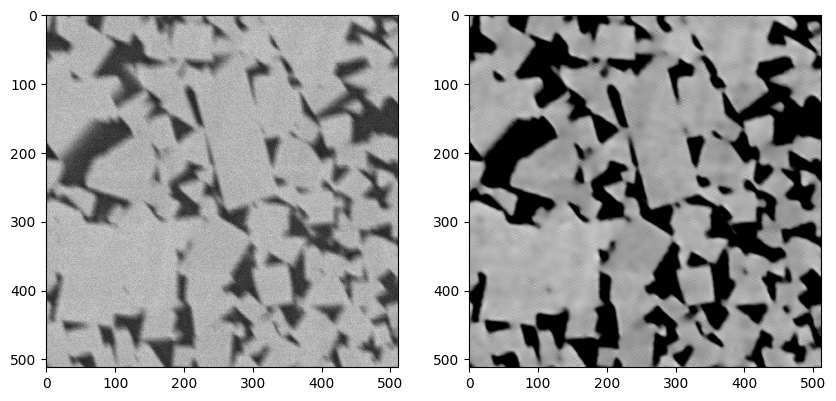

In [34]:
dataset_path = dataset.__dict__['root']
classes_folders = os.listdir(dataset_path)
classes_folders_images = [os.listdir(dataset_path + '/' + folder) for folder in classes_folders]
classes_folders_images_num = [len(os.listdir(dataset_path + '/' + folder)) for folder in classes_folders]
img_transform = dataset.__dict__['transform']

i=1
j=0

image_path = dataset_path + '/' + classes_folders[i] + '/' + classes_folders_images[i][j]

img = Image.open(image_path)
image = transform(img)
image = image.unsqueeze(0).to(device)

target_layers = [model.__dict__['_modules']['enc_b'].__dict__['_modules']['blocks'].__dict__['_modules']['10']]
input_tensor = image

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())


targets = [SemanticSegmentationTarget(0,image[0].cpu().detach().numpy())]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

fig,axes=plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(img,cmap='gray')
axes[1].imshow(grayscale_cam,cmap='gray')

In [21]:
grayscale_cam.shape

(1, 512, 512)